In [1]:
ciaover -v

The current environment is configured for:
  CIAO        : CIAO 4.15 Monday, November 21, 2022
  Tools       : Package release 1  Monday, November 21, 2022
  Sherpa      : Package release 1  Monday, November 21, 2022
  Obsvis      : Not Installed
  Core        : Package release 1  Monday, November 21, 2022
  Contrib     : Package release 1  Tuesday, January 24, 2023
  bindir      : /export/ciao_from_source/ciao-4.15/bin
  Python path : /export/ciao_from_source/ciao-4.15/ots/bin
  CALDB       : 4.10.2

CIAO Installation: Linux
System information:
Linux lenin.cfa.harvard.edu 4.18.0-425.13.1.el8_7.x86_64 #1 SMP Thu Feb 2 13:01:45 EST 2023 x86_64 x86_64 x86_64 GNU/Linux


In [2]:
download_chandra_obsid 635 --quiet --exclude evt2,vvref,adat,eph1,osol,full_img,cntr_img,oif,aqual,readme

In [ ]:
chandra_repro 635 out=./ clob+ verb=0

## Look at the data


Okay, this is not a great example but this observation has a couple of very close sources that we can experiment with.  


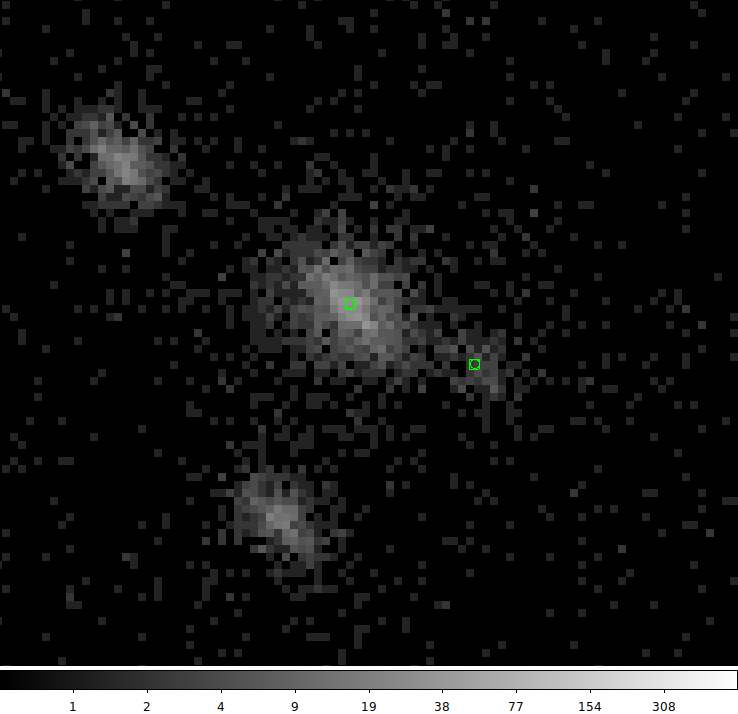

In [83]:
ds9 acisf00635_repro_evt2.fits -log \
  -pan to  16:27:18.0805 -24:28:54.728 fk5 \
  -zoom to 8 \
  -regions command "fk5; point 246.8233546631 -24.4824038252" \
  -regions command "fk5; point 246.8256837046 -24.4813770818" \
  -saveimage png events.png -exit

display < events.png

## Regions and PSFs

We need two things.

1. Regions for each source and
2. "The" PSF for each source.

Just for simplicity I'm going to use the `psf_contour` script to do this since it simulates the PSF and creates regions.

If you already have regions, then you can use the `simulate_psf` script to create the PSF.  Or run `ChaRT` and `marx` to simulate the PSF.  It's important that the PSF be normalized so that the sum of the pixels is ~ 1.0. That is that the PSF is representing the probability of event being detected at (x,y) given a source at the input location.




These source really don't overlap that much but for illustrative purposes I'll make the region bigger by increating the `fraction` parameter.  

In [84]:
psf_contour acisf00635_repro_evt2.fits faint pos="246.8233546631,-24.4824038252" \
  method=ecf_ellipse clob+ frac=0.95 verb=0


In [85]:
psf_contour acisf00635_repro_evt2.fits bright pos="246.8256837046,-24.4813770818" \
  method=ecf_ellipse clob+ frac=0.95 verb=0


and now we can display the regions

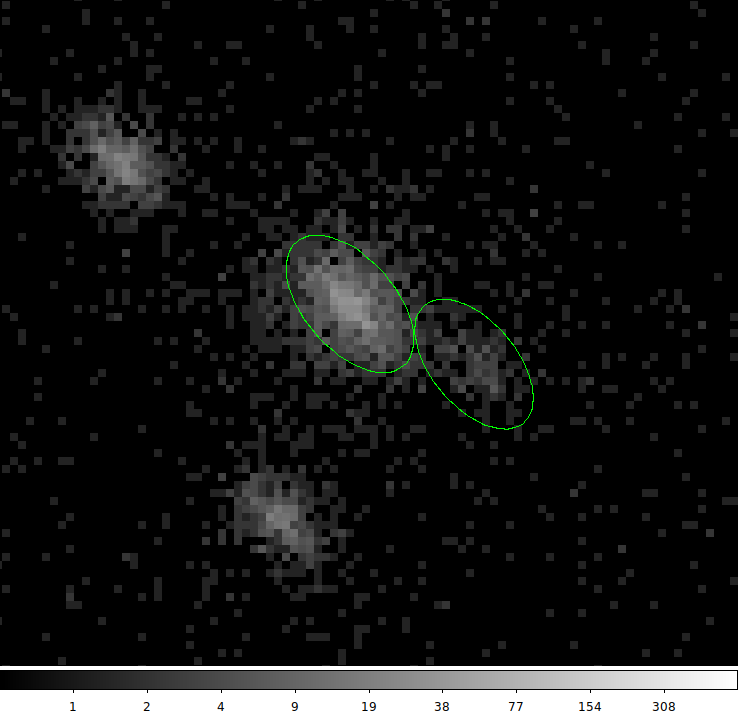

In [86]:
ds9 acisf00635_repro_evt2.fits -log \
  -pan to  16:27:18.0805 -24:28:54.728 fk5 \
  -zoom to 8 \
  -region bright_i0001_src.reg \
  -region faint_i0001_src.reg \
  -saveimage png events.png -exit

display < events.png

Well, the regions really don't overlap.  

But that's okay, this same approach is applicable when the regions do overlap.


## Overlapping regions

Next thing I want to do is create regions that have the other region excluded from it.

This is easy to do with the CXC region module.

I also will go ahead and create the region that is the intersection, ie overlap between the two regions, and the region that is the union of the two regions.  I'll use the later to restrict the analysis to just the bounding box around these sources.  

In [87]:
python << EOM
from region import CXCRegion

faint = CXCRegion("faint_i0001_src.reg")
bright = CXCRegion("bright_i0001_src.reg")

faint_no_bright = faint - bright
faint_no_bright.write("faint_no_bright.reg", clobber=True, fits=True)

bright_no_faint = bright - faint
bright_no_faint.write("bright_no_faint.reg", clobber=True, fits=True)

overlap = faint * bright   # Intersection 
overlap.write("overlap.reg", clobber=True, fits=True)

bounds = faint + bright    # Union
bounds.write("bounds.reg", clobber=True, fits=True)
EOM


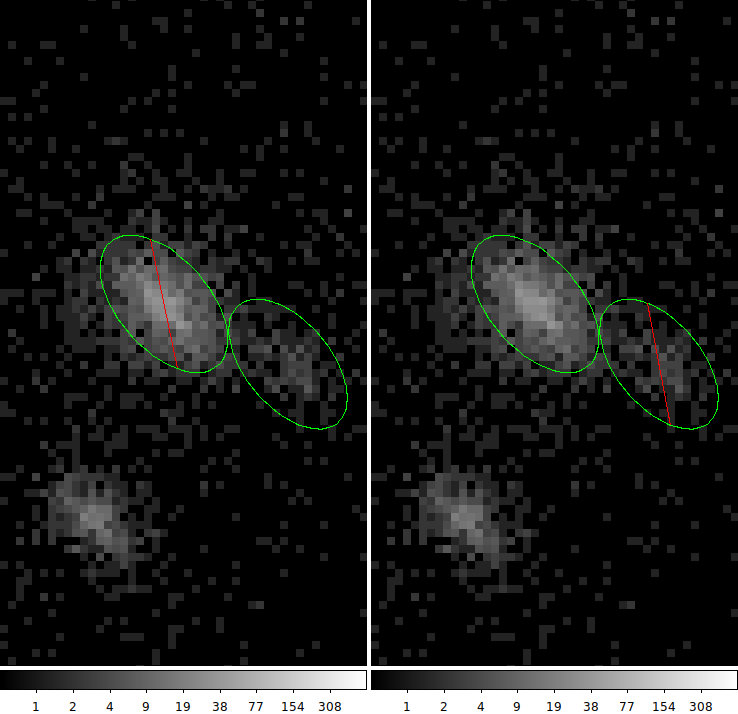

In [88]:
ds9 \
  acisf00635_repro_evt2.fits -log \
  -pan to  16:27:18.0805 -24:28:54.728 fk5 \
  -zoom to 8 \
  -region faint_no_bright.reg \
  acisf00635_repro_evt2.fits -log \
  -pan to  16:27:18.0805 -24:28:54.728 fk5 \
  -zoom to 8 \
  -region bright_no_faint.reg \
  -saveimage png excluded_regions.png -exit

display < excluded_regions.png


## Turning PSF into expected counts

Next I want to turn the PSFs from a probabiliy into an expected value, ie the surface brightness (counts/pixel) in each pixel.

Basically just need to get the counts in each of the regions with the overlaps cutout and the PSF fraction of the same.  The just multiple the PSF image by the counts divided by the psf fraction.


In [89]:
python << EOM
from ciao_contrib.runtool import dmstat

events = "acisf00635_repro_evt2.fits[energy=500:7000]"
psf_faint = "faint_i0001.psf"
psf_bright = "bright_i0001.psf"


dmstat(f'{events}[sky=region(faint_no_bright.reg)][bin sky=1]', centroid=False)
counts_faint = dmstat.out_sum

dmstat(f'{events}[sky=region(bright_no_faint.reg)][bin sky=1]', centroid=False)
counts_bright = dmstat.out_sum

print(counts_bright, counts_faint)

dmstat(f'{psf_faint}[sky=region(faint_no_bright.reg)][bin sky=1]', centroid=False)
psffrac_faint = dmstat.out_sum

dmstat(f'{psf_bright}[sky=region(bright_no_faint.reg)][bin sky=1]', centroid=False)
psffrac_bright = dmstat.out_sum

print(psffrac_bright, psffrac_faint)


from ciao_contrib.runtool import dmimgcalc

dmimgcalc(psf_faint, outfile="faint.img", 
          operation=f"imgout=img1*({counts_faint}/{psffrac_faint})", clobber=True)

dmimgcalc(psf_bright, outfile="bright.img", 
          operation=f"imgout=img1*({counts_bright}/{psffrac_bright})", clobber=True)



EOM

1326 177
0.95056893444 0.94013478787


## Estimate a background

It wasn't mentioned but I want to leave open the possiblity that there are background events in the source regions.

For this I'm just going to use a flat/constant estimate of the background surface brightness.  I'll get the 
background count rate using a circular regions just offset from these sources

In [90]:
dmstat acisf00635_repro_evt2.fits"[energy=500:7000][sky=circle(4113,4834,25)][bin sky=1]" cen- sig- verb=0

bkg_cts=$(pget dmstat out_sum)
bkg_area=$(pget dmstat out_good)
bkg_rate=$(python -c "print(1.0*$bkg_cts/$bkg_area)")
echo $bkg_rate

0.018867924528301886


### Now let's filter the event file to just the events around the sources

In [91]:
dmcopy acisf00635_repro_evt2.fits"[sky=bounds(region(bounds.reg))][energy=500:7000]" bounds.evt clob+


### Create background image

And now we create a flat/constant background with all the pixel values equal to the background rate we just computed.

In [92]:
# an estimate of background counts per pixel
dmimgcalc bounds.evt"[bin sky=1]" none bkg.img op=imgout="(img1-img1)+${bkg_rate}" clob+  

## Magic happens

This is where things get fun.  

What I want to do now is for each event look up the expected counts in the faint image, the bright image, and the background image.

Turns out that this is easy to do with `dmimgpick`.  The only thing "special" here is that to make things easier I'm going to rename the FITS extensions on-the-fly using the DM virtual file syntax.

The way dmimgpick works is that it creates a new column in the output file with the same name as the input image. I'm going to just keep adding columns for each of the 3 files

In [93]:
dmimgpick bounds.evt faint.img"[1][faint]" evts_to_faint method=close clob+

In [94]:
dmimgpick evts_to_faint bright.img"[1][bright]" evts_to_bright method=close clob+

In [95]:
dmimgpick evts_to_bright bkg.img"[1][bkg]" evts_weights method=close clob+

In [96]:
dmlist evts_weights cols

 

⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼

Columns for Table Block EVENTS

⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼⎼

 
ColNo  Name                 Unit        Type             Range            Null
   1   time                 s            Real8          72038003.8537459970:72141281.8325330019 -          S/C TT corresponding to mid-exposure
   2   expno                             Int4           0:2147483647         -          Exposure number of CCD frame containing event
   3   ccd_id                            Int2           0:9                  -          CCD reporting event
   4   node_id                           Int2           0:3                  -          CCD serial readout amplifier node
   5   chip(chipx,chipy)    pixel        Int2           1:1024               -          Chip coords
   6   tdet(tdetx,tdety)    pixel        Int2           1:8192               9999       ACIS tiled detector coor

## Make assignments

We can now assign events based on the 

We assume all the events are attributed to either the faint source, the bright source, or the background.

For each event we know the probability that it belongs to each of these categories.  The sum of these probabilities must equal 1.0.

We generate a uniform random variable and use that to select which ID to assign each event to.

I'm using `dmtcalc`.  The variable that start with "." are not written to the output file, eg `.sum` and `.randval`.  The only variable written to the output is `src_id`.  `#rand(1234)` is a uniform random number with random seed = 1234.

Hopefull the conditional logic is clear


In [97]:
cat << EOM > expr.lis
.sum=(bkg_img+faint_img+bright_img)
.prob_faint=(faint_img/.sum)
.prob_bright=(bright_img/.sum)
.randval=#rand(1234)
src_id="background"
if(.randval<=.prob_faint)then(src_id="faint")
if((.randval>.prob_faint)&&(.randval<=(.prob_faint+.prob_bright)))then(src_id="bright")
EOM

dmtcalc evts_weights evts_ids exp=@expr.lis clob+


## Split the event files

Now we just splt the event list into different files based on the `src_id` value

In [98]:
dmcopy evts_ids"[src_id=faint]" faint.evts clob+
dmcopy evts_ids"[src_id=bright]" bright.evts clob+
dmcopy evts_ids"[src_id=background]" bkg.evts clob+


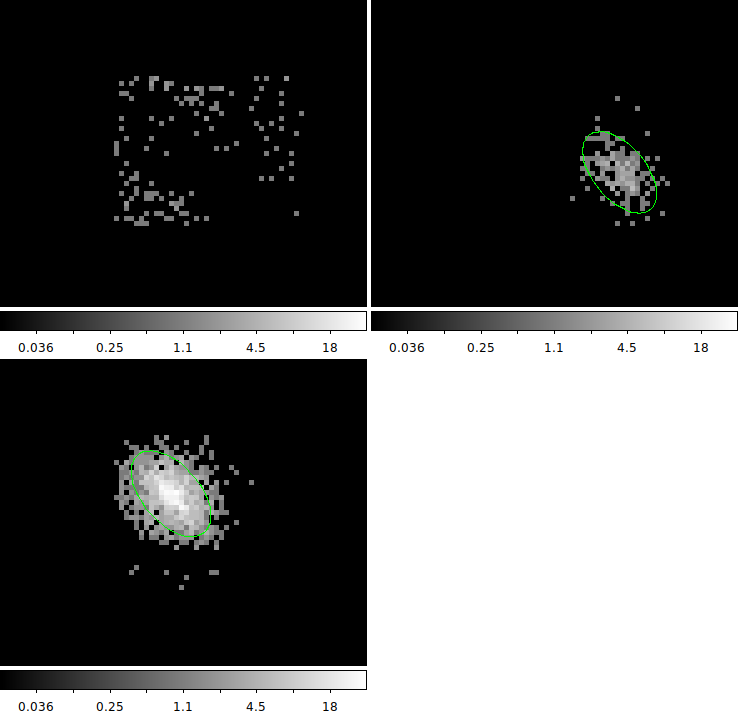

In [99]:
ds9 bkg.evts -log \
  -pan to  16:27:18.0805 -24:28:54.728 fk5 \
  -zoom to 5 \
  faint.evts -log \
  -pan to  16:27:18.0805 -24:28:54.728 fk5 \
  -zoom to 5 \
  -region faint_i0001_src.reg \
  bright.evts -log \
  -pan to  16:27:18.0805 -24:28:54.728 fk5 \
  -zoom to 5 \
  -region bright_i0001_src.reg \
  -tile grid\
  -match colorbar -match scale -match scalelimits \
  -saveimage png separated.png -exit

display < separated.png
  